# Some overview visualizations for the dataset

## Load and preprocess the data

In [1]:
import utils.KEprocessing
combined_df = utils.KEprocessing.prepare_final_df()

/Users/oxana/projects/Research-KalmarEnergy/utils/KEprocessing.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[hour_columns] = df_filtered[hour_columns].mask((df_filtered[hour_columns] < 0) | (df_filtered[hour_columns].gt(thresholds, axis=0)))
/Users/oxana/projects/Research-KalmarEnergy/utils/KEprocessing.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[hour_columns] = df_filtered[hour_columns].apply(lambda x: x.fillna(row_means[x.name]), axis=1)


# KE customers by category and year

In [2]:
customer_counts = combined_df.groupby('ISPRIVATEPERSON')['CUSTOMER'].nunique()
customer_counts

ISPRIVATEPERSON
Ja     5097
Nej    1388
Name: CUSTOMER, dtype: int64

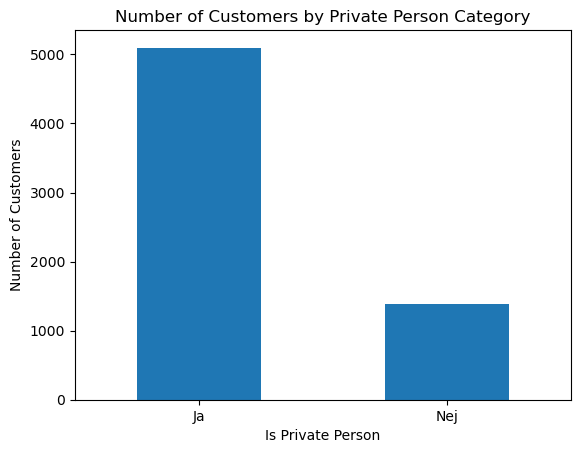

In [5]:
import matplotlib.pyplot as plt
customer_counts.plot(kind='bar')
plt.title('Number of Customers by Private Person Category')
plt.xlabel('Is Private Person')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)  # To keep the labels on the x-axis vertical
plt.show()

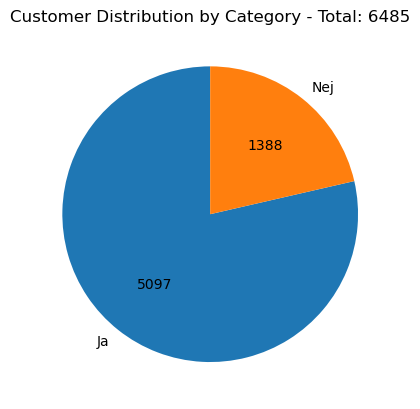

In [6]:
# Now calculate the number of unique customers for the new categories
customer_counts = combined_df.groupby('ISPRIVATEPERSON')['CUSTOMER'].nunique()

# Plot the pie chart with the actual numbers and the total
total_customers = customer_counts.sum()
customer_counts.plot(kind='pie', autopct=lambda p: f'{p * total_customers / 100 :.0f}', startangle=90, labels=customer_counts.index)
plt.title(f'Customer Distribution by Category - Total: {total_customers}')
plt.ylabel('')
plt.show()

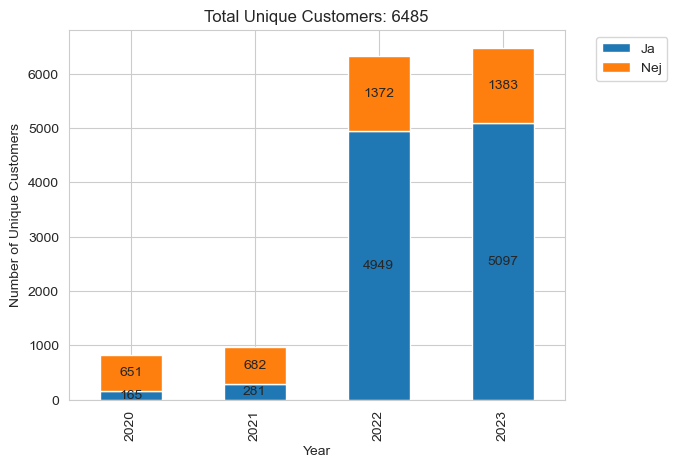

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# count unique customers per year split by category
customer_yearly = combined_df.groupby(['YEAR', 'ISPRIVATEPERSON'])['CUSTOMER'].nunique().unstack()

# Plot the stacked bar chart using seaborn
ax = customer_yearly.plot(kind='bar', stacked=True, legend=False)
# Display the total unique number of customers in combined dataframe
total_unique_customers = combined_df['CUSTOMER'].nunique()

plt.xlabel('Year')
plt.ylabel('Number of Unique Customers')

# Add labels on top of each stacked bar with the total number of customers for that year
for container in ax.containers:
    ax.bar_label(container, label_type='center')

# Move the legend outside of the plot
plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add a title with the total unique customers
plt.title(f'Total Unique Customers: {total_unique_customers}')

plt.show()



## Number of Customers per Area

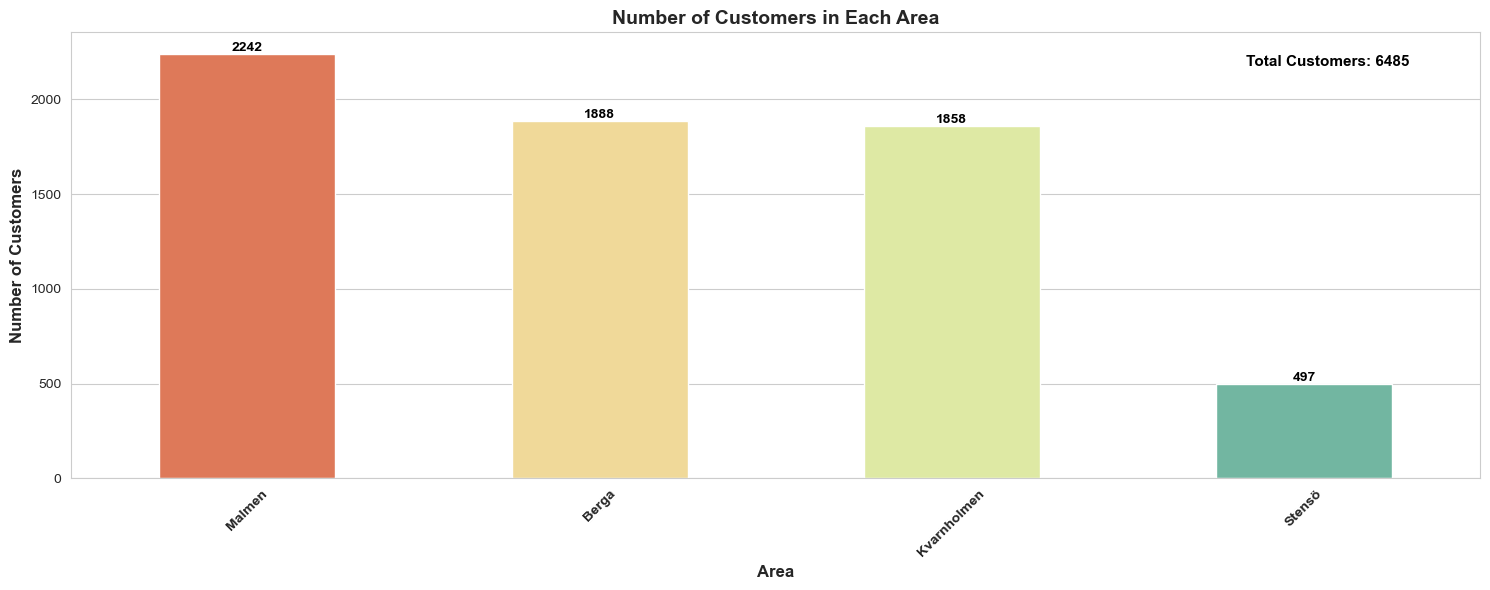

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by 'AREA' and count the unique number of 'CUSTOMER'
customers_per_area = combined_df.groupby('AREA')['CUSTOMER'].nunique()

# Calculate the total number of unique customers
total_customers = customers_per_area.sum()

# Convert to DataFrame and reset index for better readability
customers_per_area_df = customers_per_area.reset_index()

# Rename columns for clarity
customers_per_area_df.columns = ['AREA', 'Number of Customers']

# Sort the areas for better visualization
customers_per_area_df = customers_per_area_df.sort_values('Number of Customers', ascending=False)

# Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Create a bar chart with Seaborn with narrower bars
plt.figure(figsize=(15, 6))
barplot = sns.barplot(x='AREA', y='Number of Customers', data=customers_per_area_df, 
                      palette='Spectral', width=0.5)  # Set width to desired value

# Rotate the x-axis labels for better readability and adjust fontsize and fontweight
plt.xticks(rotation=45, fontsize=10, fontweight='bold')

# Annotate the number of customers on top of each bar
for bar in barplot.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, int(yval), 
             ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

plt.xlabel('Area', fontsize=12, fontweight='bold')
plt.ylabel('Number of Customers', fontsize=12, fontweight='bold')
plt.title('Number of Customers in Each Area', fontsize=14, fontweight='bold')

# Add the total number of customers in the top right corner of the plot
plt.annotate(f'Total Customers: {total_customers}', xy=(0.95, 0.95), xycoords='axes fraction',
             fontsize=11, color='black', fontweight='bold', ha='right', va='top')

# Adjust the layout to fit the x-axis labels
plt.tight_layout()

# Show the plot
plt.show()
